<a href="https://colab.research.google.com/github/Shisiajoy/MACHINE-LEARNING/blob/main/rsna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp

from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input , Flatten
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Set up Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = 'shisiajoy'
os.environ['KAGGLE_KEY'] = '1dd180f469c6368d77b117006c289cd1'




In [3]:
pip install pillow


In [4]:
# Install Kaggle API if not already installed
!pip install kaggle


In [5]:
!kaggle datasets download -d gauravduttakiit/rsna-screening-mammography-breast-cancer-detection


Dataset URL: https://www.kaggle.com/datasets/gauravduttakiit/rsna-screening-mammography-breast-cancer-detection
License(s): CC0-1.0
100% 998M/0.98G [00:35<00:00, 35.8MB/s]
100% 0.98G/0.98G [00:35<00:00, 29.8MB/s]


In [6]:
!unzip rsna-screening-mammography-breast-cancer-detection.zip -d /content/rsna_mammography_dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/rsna_mammography_dataset/output/train/63617_1917877119.png  
  inflating: /content/rsna_mammography_dataset/output/train/63617_887426674.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_1186739164.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_1657034655.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_335778602.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_625719002.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_1154699412.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_549972940.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_599167493.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_939566995.png  
  inflating: /content/rsna_mammography_dataset/output/train/63627_1214214469.png  
  inflating: /content/rsna_mammography_dat

In [7]:
traininfo = pd.read_csv("/content/rsna_mammography_dataset/train.csv")

In [8]:
traininfo.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,cancer
0,2,10006,462822612,L,CC,61.0,0,29,10006_L,0
1,2,10006,1459541791,L,MLO,61.0,0,29,10006_L,0
2,2,10006,1864590858,R,MLO,61.0,0,29,10006_R,0
3,2,10006,1874946579,R,CC,61.0,0,29,10006_R,0
4,2,10011,220375232,L,CC,55.0,0,21,10011_L,0


In [9]:
# Define the path to your image folder
image_folder_path = '/content/rsna_mammography_dataset/output/train'



In [10]:
import pandas as pd
import os
from PIL import Image  # Make sure to import Image from PIL

# Load the dataset
traininfo = pd.read_csv("/content/rsna_mammography_dataset/train.csv")

# Define the path to your image folder
image_folder_path = '/content/rsna_mammography_dataset/output/train'

def load_image(patient_id, image_id, image_folder_path):
    # Construct the image filename based on the dataset
    image_filename = f"{patient_id}_{image_id}.png"
    image_path = os.path.join(image_folder_path, image_filename)
    if os.path.exists(image_path):
        return Image.open(image_path)
    else:
        print(f"Image {image_filename} not found.")
        return None


In [11]:
# Example usage with a subset of images
num_images_to_process = 10
for index, row in traininfo.head(num_images_to_process).iterrows():
    patient_id = row['patient_id']
    image_id = row['image_id']
    image = load_image(patient_id, image_id, image_folder_path)
    if image:
        image.show()  # or process the image as needed


Trying to load: /content/rsna_mammography_dataset/output/train/10006_1459541791.png


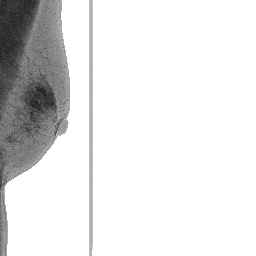

In [12]:
import pandas as pd
import os
from PIL import Image
from IPython.display import display

# Load the dataset
traininfo = pd.read_csv("/content/rsna_mammography_dataset/train.csv")

# Define the path to your image folder
image_folder_path = '/content/rsna_mammography_dataset/output/train'

def load_image(patient_id, image_id, image_folder_path):
    image_filename = f"{patient_id}_{image_id}.png"
    image_path = os.path.join(image_folder_path, image_filename)
    print(f"Trying to load: {image_path}")  # Debugging statement
    if os.path.exists(image_path):
        return Image.open(image_path)
    else:
        print(f"Image {image_filename} not found.")
        return None

# Test with a single image
test_patient_id = '10006'  # Replace with a valid patient_id
test_image_id = '1459541791'  # Replace with a valid image_id
image = load_image(test_patient_id, test_image_id, image_folder_path)
if image:
    display(image)  # Use display() for Jupyter notebooks


Displaying a cancer image:


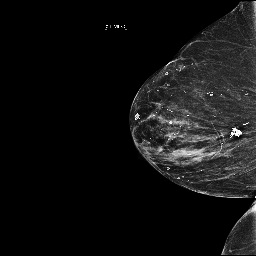

Displaying a no-cancer image:


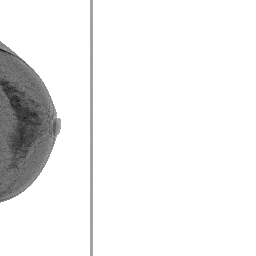

In [13]:
import pandas as pd
import os
from PIL import Image
from IPython.display import display

# Load the dataset
traininfo = pd.read_csv("/content/rsna_mammography_dataset/train.csv")

# Define the path to your image folder
image_folder_path = '/content/rsna_mammography_dataset/output/train'

def load_image(patient_id, image_id, image_folder_path):
    image_filename = f"{patient_id}_{image_id}.png"
    image_path = os.path.join(image_folder_path, image_filename)
    if os.path.exists(image_path):
        return Image.open(image_path)
    else:
        print(f"Image {image_filename} not found.")
        return None

# Group images by cancer label
def group_images_by_cancer(df, image_folder_path):
    grouped_images = {'cancer': [], 'no_cancer': []}

    # Assuming cancer column contains binary values (0 or 1)
    for _, row in df.iterrows():
        patient_id = row['patient_id']
        image_id = row['image_id']
        cancer_label = row['cancer']  # Use 'cancer' column for labeling

        image = load_image(patient_id, image_id, image_folder_path)
        if image:
            if cancer_label == 1:  # Assuming 1 indicates 'cancer'
                grouped_images['cancer'].append(image)
            elif cancer_label == 0:  # Assuming 0 indicates 'no cancer'
                grouped_images['no_cancer'].append(image)

    return grouped_images

# Test grouping images
grouped_images = group_images_by_cancer(traininfo, image_folder_path)

# Display a sample image from each group
if grouped_images['cancer']:
    print("Displaying a cancer image:")
    display(grouped_images['cancer'][0])
if grouped_images['no_cancer']:
    print("Displaying a no-cancer image:")
    display(grouped_images['no_cancer'][0])


Displaying a sample image from the train set:
cancer image:


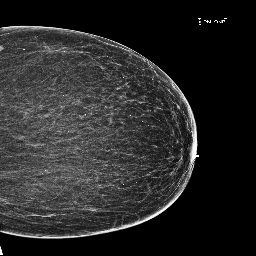

no_cancer image:


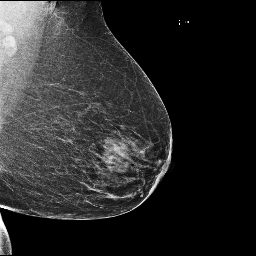

Displaying a sample image from the validation set:
cancer image:


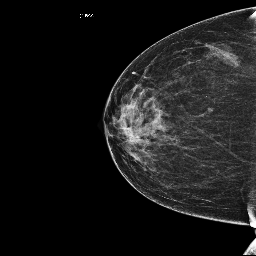

no_cancer image:


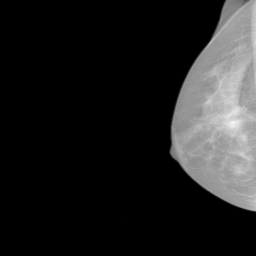

Displaying a sample image from the test set:
cancer image:


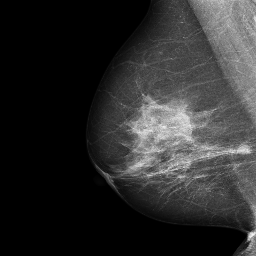

no_cancer image:


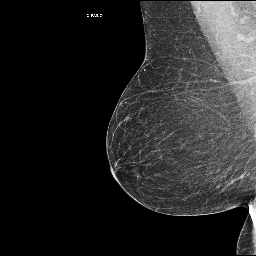

In [14]:
from sklearn.model_selection import train_test_split

# Split images into training, validation, and test sets
def split_images(grouped_images, test_size=0.2, validation_size=0.25):
    train_images = {'cancer': [], 'no_cancer': []}
    val_images = {'cancer': [], 'no_cancer': []}
    test_images = {'cancer': [], 'no_cancer': []}

    for label in ['cancer', 'no_cancer']:
        images = grouped_images[label]

        # Split into training + validation and test sets
        train_val_images, test_images[label] = train_test_split(images, test_size=test_size, random_state=42)

        # Split the training + validation set into training and validation sets
        train_images[label], val_images[label] = train_test_split(train_val_images, test_size=validation_size, random_state=42)

    return train_images, val_images, test_images

# Test grouping images
grouped_images = group_images_by_cancer(traininfo, image_folder_path)

# Split images into train, validation, and test sets
train_images, val_images, test_images = split_images(grouped_images)

# Display a sample image from each set
def display_sample_images(images, set_name):
    print(f"Displaying a sample image from the {set_name} set:")
    for label in images.keys():
        if images[label]:
            print(f"{label} image:")
            display(images[label][0])

display_sample_images(train_images, "train")
display_sample_images(val_images, "validation")
display_sample_images(test_images, "test")

In [15]:

# Print the number of images in each set
def print_image_counts(train_images, val_images, test_images):
    for label in ['cancer', 'no_cancer']:
        train_count = len(train_images[label])
        val_count = len(val_images[label])
        test_count = len(test_images[label])
        print(f"{label} images: ")
        print(f"  Training set: {train_count}")
        print(f"  Validation set: {val_count}")
        print(f"  Test set: {test_count}")

print_image_counts(train_images, val_images, test_images)

cancer images: 
  Training set: 694
  Validation set: 232
  Test set: 232
no_cancer images: 
  Training set: 32128
  Validation set: 10710
  Test set: 10710


In [16]:
import os
import shutil
import pandas as pd

# Load the dataset
traininfo = pd.read_csv("/content/rsna_mammography_dataset/train.csv")

# Define paths
base_path = '/content/rsna_mammography_dataset/output/train'
cancer_path = os.path.join(base_path, 'cancer')
no_cancer_path = os.path.join(base_path, 'no_cancer')

# Create the cancer and no_cancer directories if they don't exist
os.makedirs(cancer_path, exist_ok=True)
os.makedirs(no_cancer_path, exist_ok=True)

# Function to move images to respective directories
def organize_images(row):
    patient_id = row['patient_id']
    image_id = row['image_id']
    cancer_label = row['cancer']  # Assuming 1 indicates cancer, 0 indicates no cancer

    image_filename = f"{patient_id}_{image_id}.png"
    image_path = os.path.join(base_path, image_filename)

    # Check if the image exists
    if os.path.exists(image_path):
        if cancer_label == 1:
            shutil.move(image_path, os.path.join(cancer_path, image_filename))
        else:
            shutil.move(image_path, os.path.join(no_cancer_path, image_filename))
    else:
        print(f"Image {image_filename} not found in {base_path}.")

# Apply the function to organize images
traininfo.apply(organize_images, axis=1)
print("Images have been organized into 'cancer' and 'no_cancer' folders.")


Images have been organized into 'cancer' and 'no_cancer' folders.


In [17]:
ImageDataGenerator(rescale=1./255 , validation_split =  0.2)

In [18]:
datagenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [19]:
traingenerator = datagenerator.flow_from_directory(base_path , target_size = (150 ,150), batch_size = 32 , class_mode = 'binary' ,subset = 'training')

Found 54706 images belonging to 2 classes.


In [20]:
validationgenerator = datagenerator.flow_from_directory(base_path , target_size = (150 ,150), batch_size = 32 , class_mode = 'binary' ,subset = 'validation')

Found 0 images belonging to 2 classes.


### MODELING

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the CNN model
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

### TRAININ

In [22]:
model.fit(traingenerator, validation_data=validationgenerator,epochs = 10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1710/1710 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9769 - loss: 0.1234

ValueError: Must provide at least one structure

In [23]:
# Check the number of samples in the generators
print(f"Training samples: {traingenerator.samples}")
print(f"Validation samples: {validationgenerator.samples}")

# Ensure both have samples
if traingenerator.samples == 0:
    print("The training generator has no samples. Check the directory path and contents.")
if validationgenerator.samples == 0:
    print("The validation generator has no samples. Check the directory path and contents.")


Training samples: 54706
Validation samples: 0
The validation generator has no samples. Check the directory path and contents.


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the ImageDataGenerator with rescaling and validation split
datagenerator = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values to [0, 1]
    validation_split=0.2    # 20% of data will be used for validation
)


In [25]:
# Define the base path where your image directories are located
base_path = '/content/rsna_mammography_dataset/output/train'

# Create the training data generator
traingenerator = datagenerator.flow_from_directory(
    base_path,
    target_size=(150, 150),  # Resize images to 150x150 pixels
    batch_size=32,           # Batch size
    class_mode='binary',     # Binary classification
    subset='training'        # Use the training subset
)

# Create the validation data generator
validationgenerator = datagenerator.flow_from_directory(
    base_path,
    target_size=(150, 150),  # Resize images to 150x150 pixels
    batch_size=32,           # Batch size
    class_mode='binary',     # Binary classification
    subset='validation'      # Use the validation subset
)


Found 43766 images belonging to 2 classes.
Found 10940 images belonging to 2 classes.


In [26]:
# Print the number of samples in each generator
print(f"Training samples: {traingenerator.samples}")
print(f"Validation samples: {validationgenerator.samples}")

# Ensure the generators are not empty
if traingenerator.samples == 0:
    print("The training generator has no samples. Check the directory path and contents.")
if validationgenerator.samples == 0:
    print("The validation generator has no samples. Check the directory path and contents.")


Training samples: 43766
Validation samples: 10940
